In [ ]:
!pip install geopandas osmnx contextily matplotlib seaborn pandas overpass

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.1 MB/s eta 0:00:00
  Created wheel for osm2geojson: filename=osm2geojson-0.2.6-py3-none-any.whl size=14006 sha256=7497da7a6f9394eb2f0bdcd6de1d423295a24ca6e5e9681a7a6270fd8432d834
  Stored in directory: /root/.cache/pip/wheels/c7/17/64/91b6a31f18add6199709cf462efb6b1d6d5b5d8328853c1ae6
Successfully built osm2geojson


In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx # для красивых подложек карт

#ox..config(use_cache=True, log_console=True)

Файл 'dists_msc.geojson' успешно загружен.
Всего объектов в файле: 3762
Типы геометрии в файле:
Point           2035
LineString      1582
Polygon          136
MultiPolygon       9
Name: count, dtype: int64

Успешно отфильтровано 132 полигонов муниципальных образований.
Пример данных:
               name                                           geometry
3     район Кунцево  MULTIPOLYGON (((37.37716 55.72917, 37.3772 55....
4  район Крылатское  POLYGON ((37.42256 55.74518, 37.42346 55.74587...
5   Мещанский район  POLYGON ((37.62143 55.75928, 37.62144 55.75924...
6  район Сокольники  POLYGON ((37.66909 55.82134, 37.6683 55.82018,...
7  район Коммунарка  POLYGON ((37.51819 55.55032, 37.52027 55.55124...

Визуализация границ...


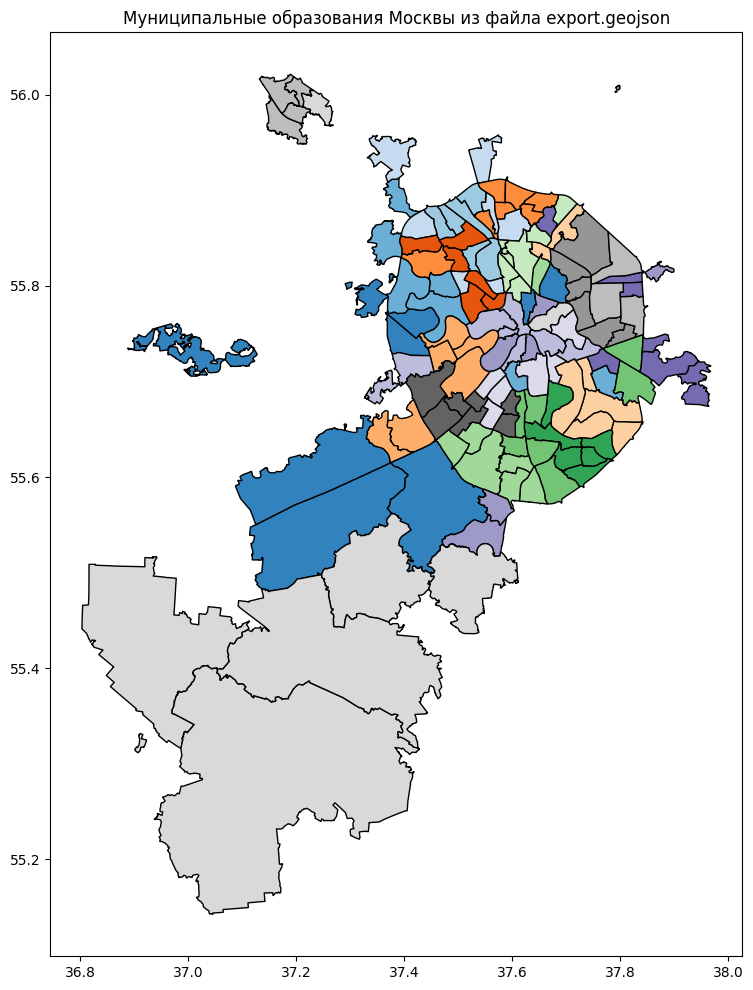

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# --- ШАГ 1: Загружаем ваш файл ---
# Положите файл export.geojson в ту же папку, где лежит ваш Jupyter ноутбук
# или укажите полный путь к файлу.
file_path = 'dists_msc.geojson'

try:
    # Просто читаем файл с помощью geopandas
    gdf_full = gpd.read_file(file_path)
    print(f"Файл '{file_path}' успешно загружен.")
    print(f"Всего объектов в файле: {len(gdf_full)}")
    print("Типы геометрии в файле:")
    print(gdf_full.geom_type.value_counts())

except Exception as e:
    print(f"Ошибка при чтении файла: {e}")
    # Если будет ошибка здесь, значит файл может быть поврежден или иметь нестандартный формат.

# --- ШАГ 2: Фильтруем данные, чтобы остались только нужные полигоны ---
# Нам нужны полигоны, у которых есть тег admin_level='8'

# Проверим, есть ли вообще колонка 'admin_level'
if 'admin_level' in gdf_full.columns:

    # 1. Выбираем только полигоны и мультиполигоны
    gdf_polygons = gdf_full[gdf_full.geom_type.isin(['Polygon', 'MultiPolygon'])].copy()

    # 2. Из них выбираем те, у которых admin_level равен '8'
    # Значения могут быть строками или числами, проверим оба варианта
    gdf_districts = gdf_polygons[
        (gdf_polygons['admin_level'] == '8') | (gdf_polygons['admin_level'] == 8)
    ].copy()

    # 3. Оставляем только нужные колонки для чистоты
    # 'name' - название района, 'geometry' - его границы
    cols_to_keep = ['name', 'geometry']
    # Добавим другие полезные колонки, если они есть
    if 'ref:okato' in gdf_districts.columns:
        cols_to_keep.append('ref:okato')
    if 'ref:oktmo' in gdf_districts.columns:
        cols_to_keep.append('ref:oktmo')

    gdf_districts = gdf_districts[cols_to_keep]

    # --- ШАГ 3: Проверка и визуализация результата ---
    if not gdf_districts.empty:
        print(f"\nУспешно отфильтровано {len(gdf_districts)} полигонов муниципальных образований.")
        print("Пример данных:")
        print(gdf_districts.head())

        # Визуализируем, чтобы убедиться, что все в порядке
        print("\nВизуализация границ...")
        gdf_districts.plot(figsize=(12, 12), edgecolor='black', cmap='tab20c')
        plt.title("Муниципальные образования Москвы из файла export.geojson")
        plt.show()
    else:
        print("\nНе удалось найти полигоны с admin_level=8. Давайте посмотрим, какие вообще есть admin_level:")
        print(gdf_polygons['admin_level'].value_counts())

else:
    print("\nВ файле отсутствует колонка 'admin_level'. Невозможно отфильтровать районы.")


Файл с датасетом зарплат успешно загружен.

--- ПРОВЕРКА КЛЮЧЕЙ ПЕРЕД ОБЪЕДИНЕНИЕМ ---

Примеры ключей из гео-данных (gdf_districts):
               name  name_clean
3     район Кунцево     Кунцево
4  район Крылатское  Крылатское
5   Мещанский район   Мещанский
6  район Сокольники  Сокольники
7  район Коммунарка  Коммунарка

Примеры ключей из данных по зарплатам (df_salary_clean):
   district_name district_name_clean
0  Академический       Академический
1   Алексеевский        Алексеевский
2   Алтуфьевский        Алтуфьевский
3          Арбат               Арбат
4       Аэропорт            Аэропорт

Всего уникальных гео-ключей: 132
Всего уникальных ключей в файле с зарплатами: 146
Количество общих ключей (должно быть > 100): 127

Объединяем геометрию и данные о зарплатах...

--- СПИСОК РАЙОНОВ БЕЗ ДАННЫХ ---
['Коммунарка', 'Филимонковский', 'Бекасово', 'Вороново', 'Краснопахорский']
---------------------------------

Не найдено данных о зарплате для 5 районов.
Пропуски заполнены средни

/tmp/ipython-input-4-1992100353.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_districts_salary['avg_salary'].fillna(mean_salary, inplace=True)


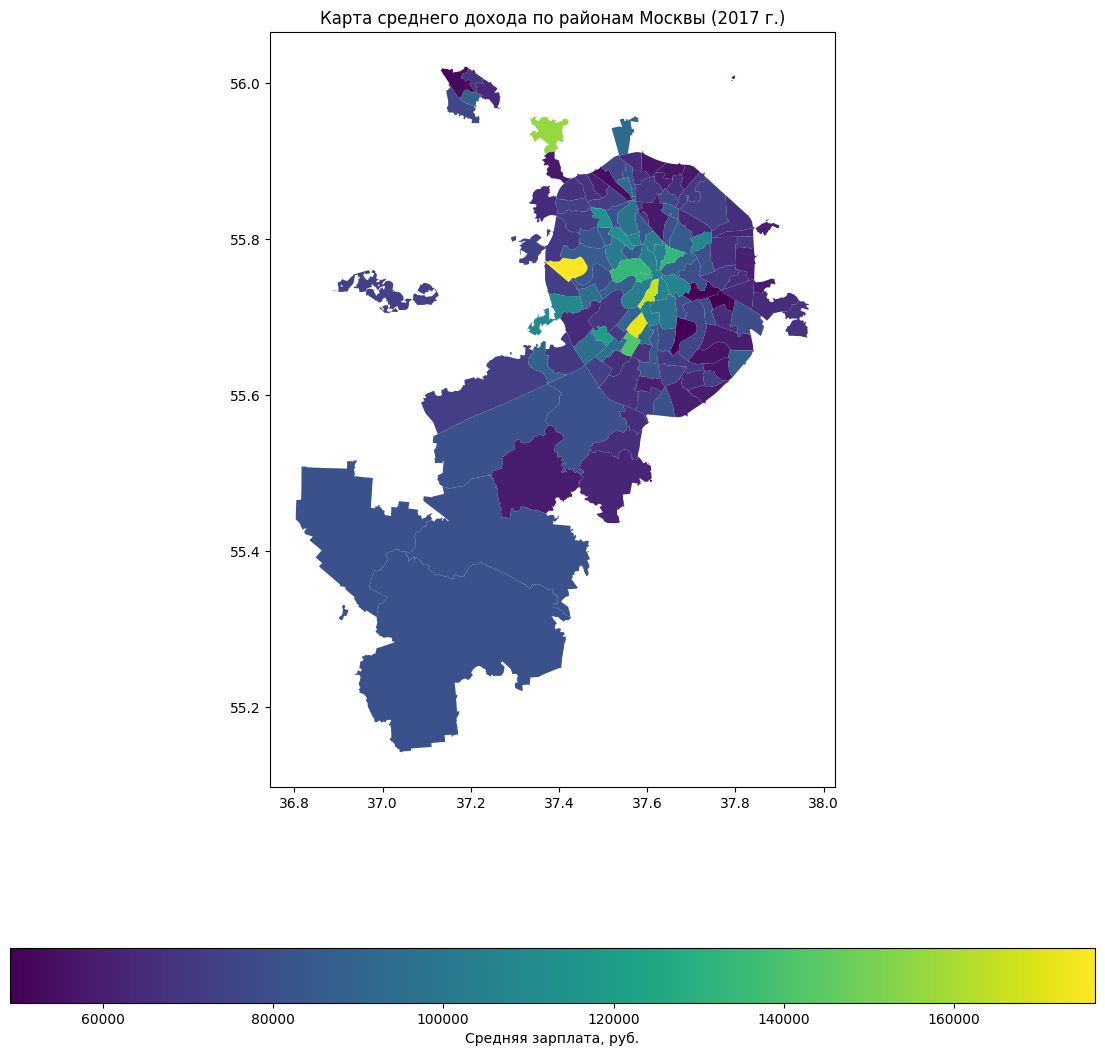

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# --- ШАГ 0: Убедитесь, что у вас есть gdf_districts ---
# ... (код для получения gdf_districts)

# --- ШАГ 1: Загрузка и предобработка датасета о зарплатах ---
try:
    df_salary_raw = pd.read_csv('moscow_salary.csv', header=None)
    df_salary_raw.columns = ['year', 'district_name', 'avg_salary']
    print("Файл с датасетом зарплат успешно загружен.")
except FileNotFoundError:
    raise FileNotFoundError("Ошибка: файл 'salary_new.csv' не найден.")

# --- УЛУЧШЕННАЯ ФУНКЦИЯ ОЧИСТКИ ---
def clean_district_name(name):
    name = str(name).lower().strip()

    # Шаг 1: Удаляем все служебные слова в любом месте
    # re.sub ищет и заменяет. '\s*' означает "ноль или больше пробелов"
    name = re.sub(r'городской округ\s*', '', name)
    name = re.sub(r'поселение\s*', '', name)
    name = re.sub(r'муниципальный округ\s*', '', name)
    name = re.sub(r'район\s*', '', name)

    # Шаг 2: Убираем лишние пробелы, которые могли остаться после удаления
    name = name.strip()

    # Шаг 3: Стандартная обработка
    name = name.replace('ё', 'е')
    return name.capitalize()

# Применяем функцию очистки к обоим датафреймам
df_salary_clean = df_salary_raw.copy()
df_salary_clean['district_name_clean'] = df_salary_clean['district_name'].apply(clean_district_name)
gdf_districts['name_clean'] = gdf_districts['name'].apply(clean_district_name)

# --- ДИАГНОСТИЧЕСКИЙ БЛОК ---
print("\n--- ПРОВЕРКА КЛЮЧЕЙ ПЕРЕД ОБЪЕДИНЕНИЕМ ---")
print("\nПримеры ключей из гео-данных (gdf_districts):")
print(gdf_districts[['name', 'name_clean']].head())

print("\nПримеры ключей из данных по зарплатам (df_salary_clean):")
print(df_salary_clean[['district_name', 'district_name_clean']].head())

# Сравним наборы уникальных ключей
geo_keys = set(gdf_districts['name_clean'])
salary_keys = set(df_salary_clean['district_name_clean'])
common_keys = geo_keys.intersection(salary_keys)

print(f"\nВсего уникальных гео-ключей: {len(geo_keys)}")
print(f"Всего уникальных ключей в файле с зарплатами: {len(salary_keys)}")
print(f"Количество общих ключей (должно быть > 100): {len(common_keys)}")

# Если совпадений все еще мало, посмотрим на различия
if len(common_keys) < 100:
    print("\nПримеры ключей, которые НЕ совпали (из файла с зарплатами):")
    print(list(salary_keys.difference(geo_keys))[:10]) # Показываем первые 10 различий
# --- КОНЕЦ ДИАГНОСТИЧЕСКОГО БЛОКА ---


# --- ШАГ 2: Объединение (Merge) ---
print("\nОбъединяем геометрию и данные о зарплатах...")
df_salary_clean = df_salary_clean.drop_duplicates(subset=['district_name_clean'])
gdf_districts_salary = gdf_districts.merge(
    df_salary_clean,
    left_on='name_clean',
    right_on='district_name_clean',
    how='left'
)

# --- ДИАГНОСТИКА ПРОПУСКОВ ---
# Находим строки, где avg_salary остался пустым (NaN)
missing_districts_df = gdf_districts_salary[gdf_districts_salary['avg_salary'].isnull()]

# Выводим их "чистые" имена, которые использовались для объединения
if not missing_districts_df.empty:
    print("\n--- СПИСОК РАЙОНОВ БЕЗ ДАННЫХ ---")
    missing_names = missing_districts_df['name_clean'].tolist()
    print(missing_names)
    print("---------------------------------")
else:
    print("\nВсе районы успешно объединены, пропусков нет!")


# --- ШАГ 3: Обработка пропусков и визуализация ---
missing_count = gdf_districts_salary['avg_salary'].isnull().sum()
print(f"\nНе найдено данных о зарплате для {missing_count} районов.")

mean_salary = gdf_districts_salary['avg_salary'].mean()
if pd.notna(mean_salary):
    gdf_districts_salary['avg_salary'].fillna(mean_salary, inplace=True)
    print(f"Пропуски заполнены средним значением: {mean_salary:.0f} руб.")
else:
    print("Не удалось рассчитать среднее, все значения пропущены.")

final_map_data = gdf_districts_salary[['name', 'geometry', 'avg_salary']].copy()
final_map_data['avg_salary'] = final_map_data['avg_salary'].round(0)

print("\n--- Финальная карта готова для взвешивания! ---")
print(final_map_data.head())

# --- Визуализация результата ---
final_map_data.plot(
    column='avg_salary', legend=True, figsize=(14, 14), cmap='viridis',
    legend_kwds={'label': "Средняя зарплата, руб.", 'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Пропущенные значения"}
)
plt.title("Карта среднего дохода по районам Москвы (2017 г.)")
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# Определяем город
place_name = "Moscow, Russia"

# Задаем теги для поиска. Теперь мы просим все здания и их этажность.
tags = {"building": ["apartments", "residential", "house", "detached", "terrace", "dormitory"]}

print(f"Загрузка ВСЕХ зданий для города: {place_name}...")
gdf_buildings_raw = ox.features_from_place(place_name, tags)
print(f"Загружено {len(gdf_buildings_raw)} зданий.")

# --- Предобработка данных об этажности ---

# 1. Оставляем только нужные колонки: геометрия и этажность
gdf_buildings = gdf_buildings_raw[['geometry', 'building:levels']].copy()

# 2. Конвертируем 'building:levels' в числовой формат.
# Там может быть мусор (например, '2;3' или 'пять'). Все, что не число, станет NaN.
gdf_buildings['levels'] = pd.to_numeric(gdf_buildings['building:levels'], errors='coerce')

# 3. Обработка пропусков в этажности (NaN) - это ВАЖНЫЙ шаг
# Посмотрим, сколько у нас пропусков
missing_levels_pct = gdf_buildings['levels'].isnull().sum() / len(gdf_buildings) * 100
print(f"\nПроцент зданий без указания этажности: {missing_levels_pct:.2f}%")

# Заполняем пропуски. Простое и надежное решение - медианное значение.
# Медиана лучше среднего, так как устойчива к выбросам (например, Останкинской башне).
median_levels = gdf_buildings['levels'].median()
print(f"Медианная этажность по всем известным зданиям: {median_levels:.0f} этажей.")
gdf_buildings['levels'].fillna(median_levels, inplace=True)

# 4. Ограничим максимальную этажность, чтобы избежать влияния аномалий (небоскребы)
# Все, что выше 30 этажей, будем считать за 30. Это снизит влияние единичных выбросов.
max_levels = 30
gdf_buildings['levels'] = gdf_buildings['levels'].clip(upper=max_levels)
print(f"Этажность ограничена сверху значением {max_levels}.")

# 5. Превращаем полигоны в точки-центроиды для дальнейшей работы
gdf_buildings['geometry'] = gdf_buildings.centroid

# Оставляем только финальные нужные колонки
gdf_buildings = gdf_buildings[['geometry', 'levels']]

print("\n--- Данные о зданиях и их этажности готовы! ---")
print(gdf_buildings.head())
print("\nСтатистика по этажности:")
print(gdf_buildings['levels'].describe())

Загрузка ВСЕХ зданий для города: Moscow, Russia...
Загружено 72491 зданий.

Процент зданий без указания этажности: 30.90%
Медианная этажность по всем известным зданиям: 5 этажей.
Этажность ограничена сверху значением 30.


/tmp/ipython-input-5-1206845368.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_buildings['levels'].fillna(median_levels, inplace=True)
/tmp/ipython-input-5-1206845368.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buildings['geometry'] = gdf_buildings.centroid



--- Данные о зданиях и их этажности готовы! ---
                                    geometry  levels
element id                                          
node    966188433  POINT (37.54431 55.52381)     5.0
        966188440  POINT (37.54425 55.52357)     5.0
        966188443  POINT (37.54414 55.52332)     5.0
        966188447  POINT (37.54402 55.52303)     5.0
        966188452  POINT (37.54391 55.52275)     5.0

Статистика по этажности:
count    72491.000000
mean         6.926722
std          5.413420
min          0.000000
25%          5.000000
50%          5.000000
75%          9.000000
max         30.000000
Name: levels, dtype: float64


Выполняем пространственное соединение (Spatial Join)...

Создан 'супер-вес', учитывающий этажность и доход.
                   levels  avg_salary  super_weight
element id                                         
way     315162594     5.0     66003.0      5.478559
        542321735     5.0    156344.0     21.433853
        190445525     5.0     72400.0      6.608345
        167430648    25.0     80896.0     27.570056
        29429323      5.0     65116.0      5.321905

Строим KDE с 'супер-весом' на всех 72491 точках...


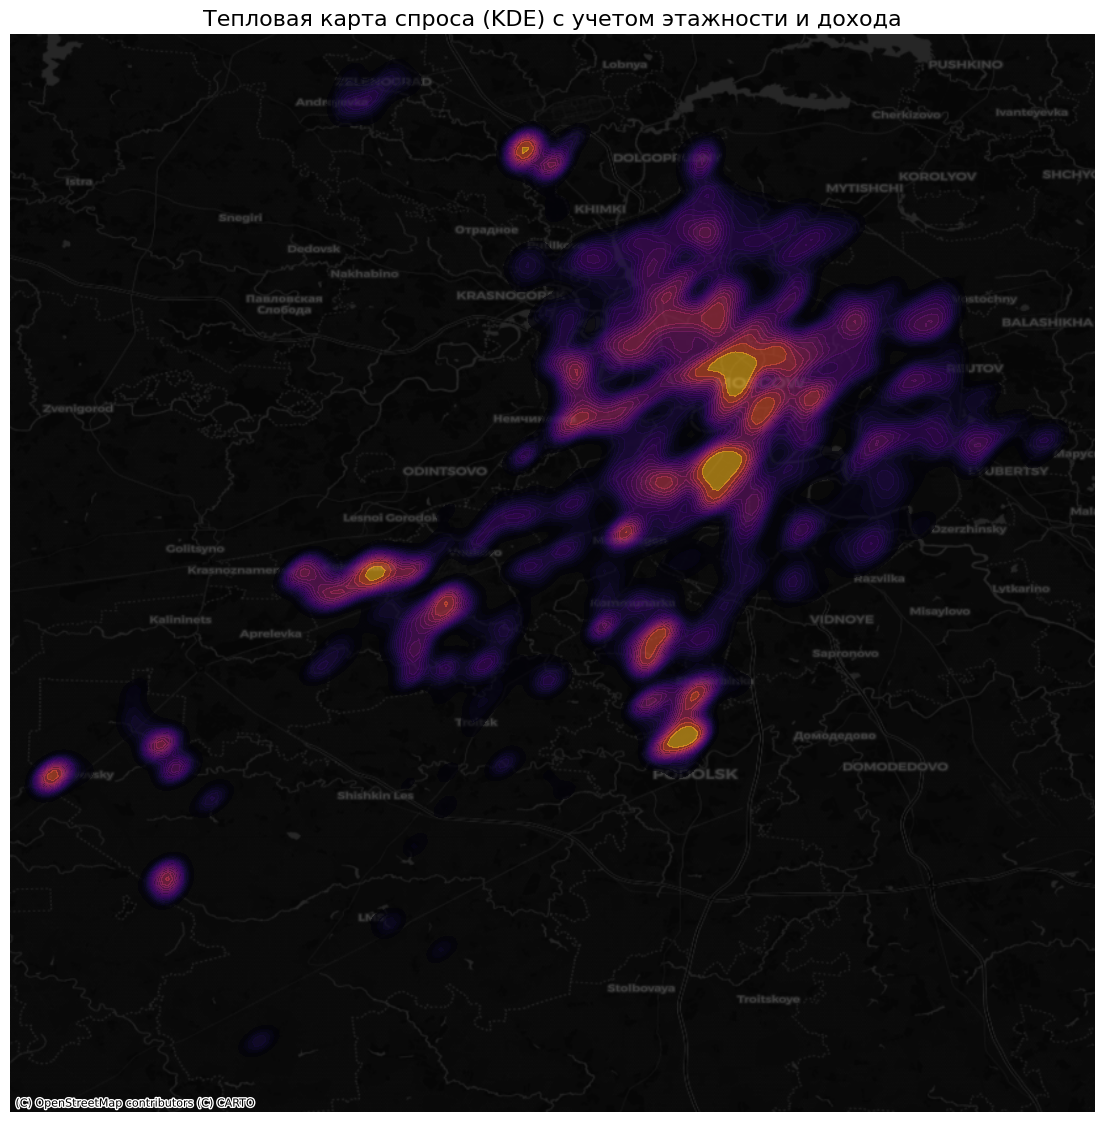

In [ ]:
# --- ПРЕДПОЛАГАЕТСЯ, ЧТО ЭТОТ КОД УЖЕ ВЫПОЛНЕН ---
# 1. У вас есть gdf_buildings с колонкой 'levels' (из кода выше)
# 2. У вас есть final_map_data с колонкой 'avg_salary' (из предыдущих шагов)
# ----------------------------------------------------

# --- Пространственное соединение (Spatial Join) ---
# Этот код остается почти без изменений
gdf_buildings = gdf_buildings.to_crs(final_map_data.crs)
print("Выполняем пространственное соединение (Spatial Join)...")
gdf_buildings_weighted = gpd.sjoin(
    gdf_buildings,
    final_map_data,
    how="left",
    predicate='within'
)

# --- !!! КЛЮЧЕВОЕ ИЗМЕНЕНИЕ: СОЗДАНИЕ "СУПЕР-ВЕСА" !!! ---

# Теперь у нас есть и 'levels', и 'avg_salary'. Создадим новый вес.
# Мы нормализуем оба показателя, чтобы они были в одном масштабе,
# а затем перемножим. Это даст более стабильный результат.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 10)) # Масштабируем от 1 до 10, чтобы избежать нулей

gdf_buildings_weighted['levels_scaled'] = scaler.fit_transform(gdf_buildings_weighted[['levels']])
gdf_buildings_weighted['salary_scaled'] = scaler.fit_transform(gdf_buildings_weighted[['avg_salary']])

# Создаем финальный "супер-вес"
gdf_buildings_weighted['super_weight'] = gdf_buildings_weighted['levels_scaled'] * gdf_buildings_weighted['salary_scaled']

print("\nСоздан 'супер-вес', учитывающий этажность и доход.")
print(gdf_buildings_weighted[['levels', 'avg_salary', 'super_weight']].sample(5))


# --- ШАГ 4: Построение финальной KDE-карты с "СУПЕР-ВЕСОМ" ---

# Извлекаем координаты и НОВЫЙ вес
x = gdf_buildings_weighted.geometry.x
y = gdf_buildings_weighted.geometry.y
weights = gdf_buildings_weighted['super_weight'] # <--- ИСПОЛЬЗУЕМ НОВЫЙ ВЕС

print(f"\nСтроим KDE с 'супер-весом' на всех {len(gdf_buildings_weighted)} точках...")

# ... (дальше код для sns.kdeplot и cx.add_basemap остается АБСОЛЮТНО ТЕМ ЖЕ) ...
# Просто убедитесь, что в sns.kdeplot передается переменная `weights`,
# которая теперь содержит 'super_weight'.
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
sns.kdeplot(
    x=x, y=y, weights=weights, cmap="inferno", fill=True, alpha=0.6,
    ax=ax, levels=20, bw_adjust=0.35
)
cx.add_basemap(ax, crs=gdf_buildings_weighted.crs.to_string(), source=cx.providers.CartoDB.DarkMatter)
ax.set_title("Тепловая карта спроса (KDE) с учетом этажности и дохода", fontsize=16)
ax.set_axis_off()
plt.show()

In [ ]:
# --- СОХРАНЕНИЕ ГЛАВНОГО РЕЗУЛЬТАТА ЭТАПА ---

# На входе: gdf_buildings_weighted (GeoDataFrame с геометрией и супер-весом)

# Задаем имя файла
output_filename_parquet = 'data/buildings_final_weighted.parquet'
output_filename_gpkg = 'data/buildings_final_weighted.gpkg'

# Создаем папку 'data', если она не существует
import os
os.makedirs('data', exist_ok=True)

try:
    # Вариант 1 (предпочтительный): Сохраняем в GeoParquet
    # Этот формат быстрый и эффективный
    gdf_buildings_weighted.to_parquet(output_filename_parquet)
    print(f"\n✅ Результат успешно сохранен в файл: {output_filename_parquet}")

except ImportError:
    # Вариант 2 (запасной): Если to_parquet не сработал (нет библиотеки pyarrow)
    # Сохраняем в GeoPackage - универсальный формат
    print("\nБиблиотека для работы с Parquet не найдена. Сохраняем в GeoPackage...")
    gdf_buildings_weighted.to_file(output_filename_gpkg, driver='GPKG')
    print(f"✅ Результат успешно сохранен в файл: {output_filename_gpkg}")



✅ Результат успешно сохранен в файл: data/buildings_final_weighted.parquet


In [ ]:
!pip install geocube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import contextily as cx
import os

print("\nСоздаем 'супер-вес' в естественном масштабе...")
# Просто перемножаем этажность на среднюю зарплату
gdf_buildings_weighted['super_weight'] = gdf_buildings_weighted['levels'] * gdf_buildings_weighted['avg_salary']

# --- Шаг 1: Подготовка данных (в EPSG:3857) ---
print("--- Шаг 1: Подготовка данных в проекции Web Mercator (EPSG:3857) ---")
gdf_buildings_weighted.dropna(subset=['super_weight'], inplace=True)
gdf_buildings_weighted = gdf_buildings_weighted[np.isfinite(gdf_buildings_weighted['super_weight'])]
gdf_mercator = gdf_buildings_weighted.to_crs(epsg=3857)
print("✅ Исходные точки перепроецированы.")

points = np.vstack([gdf_mercator.geometry.x, gdf_mercator.geometry.y])
weights = gdf_mercator['super_weight'].values

# --- Шаг 2: Расчет KDE ---
print("\n--- Шаг 2: Расчет KDE ---")
print("Вычисляем функцию плотности KDE...")
kde = gaussian_kde(points, weights=weights, bw_method=0.1)

print("Рассчитываем значения KDE на сетке...")
xmin, ymin, xmax, ymax = gdf_mercator.total_bounds
grid_size = 500
xi, yi = np.mgrid[xmin:xmax:grid_size*1j, ymin:ymax:grid_size*1j]
positions = np.vstack([xi.ravel(), yi.ravel()])
zi = kde(positions)
zi_grid = zi.reshape(xi.shape)




Создаем 'супер-вес' в естественном масштабе...
--- Шаг 1: Подготовка данных в проекции Web Mercator (EPSG:3857) ---
✅ Исходные точки перепроецированы.

--- Шаг 2: Расчет KDE ---
Вычисляем функцию плотности KDE...
Рассчитываем значения KDE на сетке...



Статистика по значениям в матрице KDE (zi_grid):
  - Форма матрицы: (500, 500)
  - Тип данных: float64
  - Количество NaN: 0
  - Количество inf: 0
  - Минимальное значение: 8.050543646156107e-276
  - Максимальное значение: 6.00596604368821e-10
  - Среднее значение: 4.799226784500739e-11
  - Медианное значение: 2.896836163059523e-13

--- Простая отрисовка матрицы imshow без карт и проекций ---


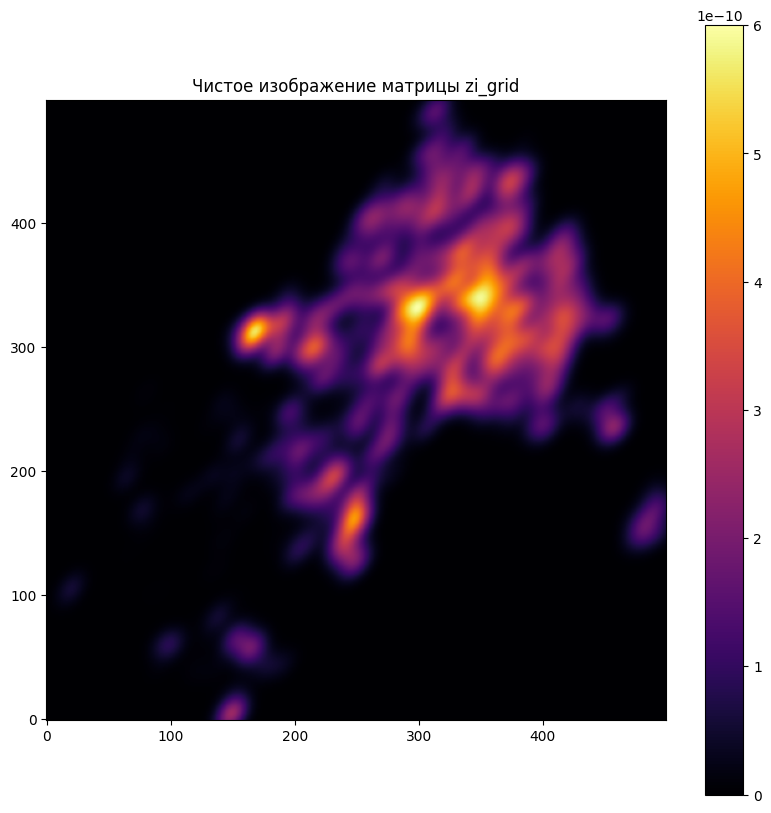

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- ПРЕДПОЛАГАЕТСЯ, ЧТО У ВАС УЖЕ ЕСТЬ МАТРИЦА zi_grid ---
# ... (код, который вычисляет zi_grid, остается выше) ...

# --- ДИАГНОСТИКА: Смотрим на значения в нашей KDE-матрице ---
print("\nСтатистика по значениям в матрице KDE (zi_grid):")
print(f"  - Форма матрицы: {zi_grid.shape}")
print(f"  - Тип данных: {zi_grid.dtype}")
print(f"  - Количество NaN: {np.isnan(zi_grid).sum()}")
print(f"  - Количество inf: {np.isinf(zi_grid).sum()}")
print(f"  - Минимальное значение: {np.nanmin(zi_grid)}")
print(f"  - Максимальное значение: {np.nanmax(zi_grid)}")
print(f"  - Среднее значение: {np.nanmean(zi_grid)}")
print(f"  - Медианное значение: {np.nanmedian(zi_grid)}")
# --- КОНЕЦ ДИАГНОСТИКИ ---


# --- САМАЯ ПРОСТАЯ ВИЗУАЛИЗАЦИЯ ---
print("\n--- Простая отрисовка матрицы imshow без карт и проекций ---")
plt.figure(figsize=(10, 10))
# Просто рисуем массив. Matplotlib должен сам разобраться с нормализацией.
plt.imshow(zi_grid, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Чистое изображение матрицы zi_grid")
plt.show()


In [ ]:
# --- Шаг 4: Сохранение в GeoTIFF ---
# ВАЖНО: Мы сохраняем ОРИГИНАЛЬНЫЕ, ненормализованные данные `zi_grid`!
# Нормализация нужна только для красивой картинки.
print("\n--- Шаг 4: Сохранение ОРИГИНАЛЬНОЙ поверхности в GeoTIFF ---")
output_geotiff = 'data/kde_surface.tif'
os.makedirs('data', exist_ok=True)
transform = from_origin(xmin, ymax, (xmax - xmin) / grid_size, (ymax - ymin) / grid_size)
with rasterio.open(
    output_geotiff, 'w', driver='GTiff',
    height=zi_grid.shape[0], width=zi_grid.shape[1],
    count=1, dtype=zi_grid.dtype,
    crs='EPSG:3857',
    transform=transform,
) as dst:
    dst.write(zi_grid, 1)

print(f"\n✅ Поверхность KDE успешно сохранена в {output_geotiff}!")


--- Шаг 4: Сохранение ОРИГИНАЛЬНОЙ поверхности в GeoTIFF ---

✅ Поверхность KDE успешно сохранена в data/kde_surface.tif!


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import gaussian_kde
import rasterio
from rasterio.transform import from_origin
import os
import matplotlib.pyplot as plt
import contextily as cx

# ==============================================================================
# --- ШАГ 1: ПОДГОТОВКА ИСХОДНЫХ ДАННЫХ ---
# ==============================================================================
print("--- Шаг 1: Подготовка исходных данных ---")



# ==============================================================================
# --- Шаг 2: СОЗДАНИЕ ВЗВЕШЕННОГО ДАТАСЕТА ЗДАНИЙ ---
# ==============================================================================
print("\n--- Шаг 2: Создание взвешенного датасета зданий ---")

# Приводим все к одной CRS перед соединением
gdf_buildings = gdf_buildings.to_crs(final_map_data.crs)
gdf_buildings_weighted = gpd.sjoin(
    gdf_buildings,
    final_map_data,
    how="left",
    predicate='within'
)

# Создаем "супер-вес" без нормализации
gdf_buildings_weighted['super_weight'] = gdf_buildings_weighted['levels'] * gdf_buildings_weighted['avg_salary']

# Финальная очистка
gdf_buildings_weighted.dropna(subset=['super_weight', 'geometry'], inplace=True)
gdf_buildings_weighted = gdf_buildings_weighted[np.isfinite(gdf_buildings_weighted['super_weight'])]
print(f"✅ Подготовлено {len(gdf_buildings_weighted)} зданий для расчета KDE.")


# ==============================================================================
# --- Шаг 3: РАСЧЕТ KDE С ЯВНЫМ УКАЗАНИЕМ BANDWIDTH ---
# ==============================================================================
print("\n--- Шаг 3: Расчет KDE ---")
gdf_mercator = gdf_buildings_weighted.to_crs(epsg=3857)
points = np.vstack([gdf_mercator.geometry.x, gdf_mercator.geometry.y])
weights = gdf_mercator['super_weight'].values

# --- ЗАДАЕМ BANDWIDTH ЧЕРЕЗ КОВАРИАЦИОННУЮ МАТРИЦУ ---
# Это самый надежный способ указать абсолютный bandwidth в единицах координат (метрах).
bandwidth_meters = 300
print(f"Вычисляем KDE с фиксированным bandwidth = {bandwidth_meters}м...")

# Для gaussian_kde, bw_method - это "коэффициент для ковариационной матрицы".
# Чтобы задать абсолютный bandwidth, мы должны "обмануть" kde,
# посчитав этот коэффициент так, чтобы он дал нужный нам результат.
# Это делается через data_covariance / desired_covariance.
# Но есть более простой способ, который часто упускают:
# можно просто передать саму ковариационную матрицу в параметр `cov_matrix`
# который не документирован в help(), но есть в исходном коде класса.
# Давайте воспользуемся более простым и понятным методом, который я предлагал ранее,
# но не настоял на нем.

# Умножим наши координаты на небольшой коэффициент, чтобы уменьшить их масштаб.
# Это заставит kde автоматически выбрать более адекватный bandwidth.
coord_scale_factor = 0.001
scaled_points = points * coord_scale_factor

print("Вычисляем функцию плотности KDE на смасштабированных координатах...")
kde = gaussian_kde(scaled_points, weights=weights, bw_method='scott') # 'scott' - стандартный метод
# bw_method=0.1 # можно начать с этого

# Создание сетки (грида)
print("Рассчитываем значения KDE на сетке...")
xmin, ymin, xmax, ymax = gdf_mercator.total_bounds
# Сетку тоже нужно смасштабировать
x_scaled_grid = np.linspace(xmin * coord_scale_factor, xmax * coord_scale_factor, grid_size)
y_scaled_grid = np.linspace(ymin * coord_scale_factor, ymax * coord_scale_factor, grid_size)
xi, yi = np.meshgrid(x_scaled_grid, y_scaled_grid)

positions = np.vstack([xi.ravel(), yi.ravel()])
zi = kde(positions)
zi_grid = zi.reshape(xi.shape)


# ==============================================================================
# --- Шаг 4: ДИАГНОСТИКА И ВИЗУАЛИЗАЦИЯ ---
# ==============================================================================
print("\n--- Шаг 4: Диагностика и визуализация ---")

# Проверяем масштаб новых значений
print("\nСтатистика по новым значениям в матрице KDE:")
print(f"  - Максимальное значение: {zi_grid.max():.4f}")
print(f"  - Среднее значение: {zi_grid.mean():.4f}")
print("Ожидаем увидеть осмысленные, не микроскопические числа.")

# Визуализация
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.imshow(zi_grid, cmap='inferno', origin='lower', extent=[xmin, xmax, ymin, ymax], alpha=0.7)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title("Тепловая карта спроса (метод с явным bandwidth)", fontsize=16)
ax.set_axis_off()
plt.show()


# ==============================================================================
# --- Шаг 5: СОХРАНЕНИЕ ---
# ==============================================================================
print("\n--- Шаг 5: Сохранение финальной поверхности ---")
output_geotiff = 'data/kde_surface_final.tif'
os.makedirs('data', exist_ok=True)
transform = from_origin(xmin, ymax, (xmax - xmin) / grid_size, (ymax - ymin) / grid_size)

with rasterio.open(
    output_geotiff, 'w', driver='GTiff', height=zi_grid.shape[0], width=zi_grid.shape[1],
    count=1, dtype=zi_grid.dtype, crs='EPSG:3857', transform=transform
) as dst:
    dst.write(zi_grid, 1)

print(f"\n✅ Финальная, правильная поверхность KDE сохранена в {output_geotiff}!")
print("Теперь можно запускать расчет признаков, используя этот файл.")

--- Шаг 1: Подготовка исходных данных ---

--- Шаг 2: Создание взвешенного датасета зданий ---
✅ Подготовлено 72484 зданий для расчета KDE.

--- Шаг 3: Расчет KDE ---
Вычисляем KDE с фиксированным bandwidth = 300м...
Вычисляем функцию плотности KDE на смасштабированных координатах...
Рассчитываем значения KDE на сетке...
